# Hospital Deterioration — Early Warning EDA

This notebook gives a compact early-warning view of the **Hospital Deterioration** dataset:  
who deteriorates, when it happens, and how physiology behaves in the hours before.

We will:
- Summarise the cohort and overall deterioration rate.
- See when events occur in the first 72 hours of admission.
- Relate risk to age, comorbidities, admission route, and length of stay.
- Compare vitals and labs over time for event vs non-event patients.
- Sketch simple early physiologic clusters and a next-12h risk signal.

Data used:
- `patients.csv`
- `vitals_timeseries.csv`
- `labs_timeseries.csv`
- `hospital_deterioration_hourly_panel.csv`
- `hospital_deterioration_ml_ready.csv`


## 1. Config & Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

sns.set(style="whitegrid", context="talk")

RANDOM_STATE = 42


## 2. Load core files & basic info

We work with five core views of the cohort:

- `patients.csv` — one row per admission (static context + outcomes).
- `vitals_timeseries.csv` — hourly vital signs.
- `labs_timeseries.csv` — hourly lab values.
- `hospital_deterioration_hourly_panel.csv` — full joined hourly panel.
- `hospital_deterioration_ml_ready.csv` — compact ML-ready table for next-12h prediction.

In [2]:
from repo_utils.pathing import resolve_data_path

# Local-first (data/raw), Kaggle fallback (/kaggle/input/...)
KAGGLE_DATASET_DIR = "hospital-deterioration-dataset"

paths = {
    "patients": resolve_data_path("patients.csv", kaggle_subdir_hint=KAGGLE_DATASET_DIR),
    "vitals": resolve_data_path("vitals_timeseries.csv", kaggle_subdir_hint=KAGGLE_DATASET_DIR),
    "labs": resolve_data_path("labs_timeseries.csv", kaggle_subdir_hint=KAGGLE_DATASET_DIR),
    "panel": resolve_data_path("hospital_deterioration_hourly_panel.csv", kaggle_subdir_hint=KAGGLE_DATASET_DIR),
    "ml_ready": resolve_data_path("hospital_deterioration_ml_ready.csv", kaggle_subdir_hint=KAGGLE_DATASET_DIR),
}

patients = pd.read_csv(paths["patients"])
vitals = pd.read_csv(paths["vitals"])
labs = pd.read_csv(paths["labs"])
panel = pd.read_csv(paths["panel"])
ml_ready = pd.read_csv(paths["ml_ready"])

for k, p in paths.items():
    print(f"[DATA] {k}: {p}")

print("[SHAPE] patients:", patients.shape)
print("[SHAPE] vitals_timeseries:", vitals.shape)
print("[SHAPE] labs_timeseries:", labs.shape)
print("[SHAPE] hourly_panel:", panel.shape)
print("[SHAPE] ml_ready:", ml_ready.shape)

def memory_usage_mb(df: pd.DataFrame) -> float:
    return df.memory_usage(deep=True).sum() / (1024 ** 2)

print(f"patients: {memory_usage_mb(patients):.2f} MB")
print(f"vitals: {memory_usage_mb(vitals):.2f} MB")
print(f"labs: {memory_usage_mb(labs):.2f} MB")
print(f"panel: {memory_usage_mb(panel):.2f} MB")
print(f"ml_ready: {memory_usage_mb(ml_ready):.2f} MB")


[SHAPE] patients: (10000, 10)
[SHAPE] vitals_timeseries: (417866, 12)
[SHAPE] labs_timeseries: (417866, 8)
[SHAPE] hourly_panel: (417866, 28)
[SHAPE] ml_ready: (417866, 22)
patients: 1.75 MB
vitals_timeseries: 59.37 MB
labs_timeseries: 25.50 MB
hourly_panel: 151.48 MB
ml_ready: 132.35 MB


### 2.1 Quick previews

In [3]:
patients.head()

,patient_id,age,gender,comorbidity_index,admission_type,baseline_risk_score,los_hours,deterioration_event,deterioration_within_12h_from_admission,deterioration_hour
0,1,24,M,2,Elective,0.2173,17,0,0,-1
1,2,74,F,3,Transfer,0.5558,33,1,0,16
2,3,65,F,7,ED,0.6325,55,0,0,-1
3,4,50,M,0,ED,0.2896,37,0,0,-1
4,5,49,M,0,ED,0.2507,22,0,0,-1


In [4]:
vitals.head()

,patient_id,hour_from_admission,heart_rate,respiratory_rate,spo2_pct,temperature_c,systolic_bp,diastolic_bp,oxygen_device,oxygen_flow,mobility_score,nurse_alert
0,1,0,68.58,14.47,96.52,37.18,108.94,78.43,none,0.0,2,0
1,1,1,67.03,13.87,94.94,37.25,111.73,79.14,none,0.0,3,0
2,1,2,69.05,14.63,94.45,37.29,111.48,78.86,none,0.0,2,0
3,1,3,69.07,14.42,95.16,37.27,110.68,76.79,none,0.0,2,0
4,1,4,73.35,15.62,95.83,37.21,110.38,75.47,none,0.0,3,0


In [5]:
labs.head()

,patient_id,hour_from_admission,wbc_count,lactate,creatinine,crp_level,hemoglobin,sepsis_risk_score
0,1,0,5.68,1.28,1.27,10.66,13.55,0.2621
1,1,1,5.46,1.18,1.22,11.94,13.65,0.3353
2,1,2,5.55,1.21,1.25,10.24,13.69,0.1678
3,1,3,5.50,1.13,1.24,10.72,13.61,0.1961
4,1,4,5.96,1.20,1.21,11.46,13.49,0.3000


In [6]:
panel.head()

,patient_id,hour_from_admission,heart_rate,respiratory_rate,spo2_pct,temperature_c,systolic_bp,diastolic_bp,oxygen_device,oxygen_flow,...,age,gender,comorbidity_index,admission_type,baseline_risk_score,los_hours,deterioration_event,deterioration_within_12h_from_admission,deterioration_hour,deterioration_next_12h
0,1,0,68.58,14.47,96.52,37.18,108.94,78.43,none,0.0,...,24,M,2,Elective,0.2173,17,0,0,-1,0
1,1,1,67.03,13.87,94.94,37.25,111.73,79.14,none,0.0,...,24,M,2,Elective,0.2173,17,0,0,-1,0
2,1,2,69.05,14.63,94.45,37.29,111.48,78.86,none,0.0,...,24,M,2,Elective,0.2173,17,0,0,-1,0
3,1,3,69.07,14.42,95.16,37.27,110.68,76.79,none,0.0,...,24,M,2,Elective,0.2173,17,0,0,-1,0
4,1,4,73.35,15.62,95.83,37.21,110.38,75.47,none,0.0,...,24,M,2,Elective,0.2173,17,0,0,-1,0


In [7]:
ml_ready.head()

,hour_from_admission,heart_rate,respiratory_rate,spo2_pct,temperature_c,systolic_bp,diastolic_bp,oxygen_device,oxygen_flow,mobility_score,...,lactate,creatinine,crp_level,hemoglobin,sepsis_risk_score,age,gender,comorbidity_index,admission_type,deterioration_next_12h
0,0,68.58,14.47,96.52,37.18,108.94,78.43,none,0.0,2,...,1.28,1.27,10.66,13.55,0.2621,24,M,2,Elective,0
1,1,67.03,13.87,94.94,37.25,111.73,79.14,none,0.0,3,...,1.18,1.22,11.94,13.65,0.3353,24,M,2,Elective,0
2,2,69.05,14.63,94.45,37.29,111.48,78.86,none,0.0,2,...,1.21,1.25,10.24,13.69,0.1678,24,M,2,Elective,0
3,3,69.07,14.42,95.16,37.27,110.68,76.79,none,0.0,2,...,1.13,1.24,10.72,13.61,0.1961,24,M,2,Elective,0
4,4,73.35,15.62,95.83,37.21,110.38,75.47,none,0.0,3,...,1.20,1.21,11.46,13.49,0.3000,24,M,2,Elective,0


## Part A — Cohort structure & outcomes

## 3. Cohort snapshot — who is in this hospital?

In [8]:
n_patients = patients["patient_id"].nunique()
mean_age = patients["age"].mean()
female_share = (patients["gender"] == "F").mean()
mean_los = patients["los_hours"].mean()
event_rate = patients["deterioration_event"].mean()
early_event_rate = patients["deterioration_within_12h_from_admission"].mean()

kpi = pd.DataFrame(
    {
        "metric": [
            "Patients",
            "Mean age",
            "Female share",
            "Mean length of stay (hours)",
            "Any deterioration event rate",
            "Early (within 12h) deterioration rate",
        ],
        "value": [
            n_patients,
            round(mean_age, 1),
            round(female_share, 3),
            round(mean_los, 1),
            round(event_rate, 3),
            round(early_event_rate, 3),
        ],
    }
)
kpi

,metric,value
0,Patients,10000.000
1,Mean age,53.700
2,Female share,0.455
3,Mean length of stay (hours),41.800
4,Any deterioration event rate,0.194
5,Early (within 12h) deterioration rate,0.031


### 3.1 KPI dashboard view

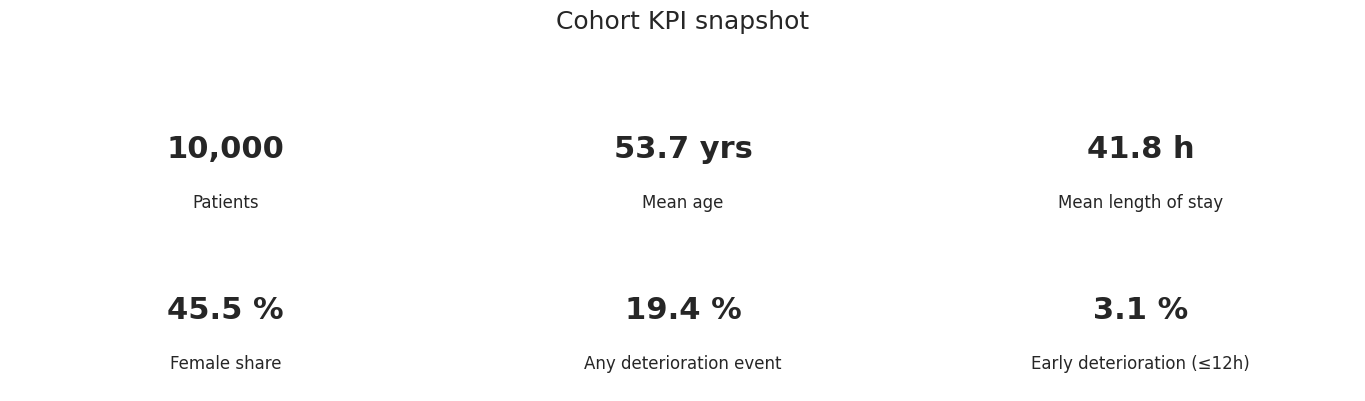

In [9]:
kpi_values = {
    "Patients": f"{n_patients:,}",
    "Mean age": f"{mean_age:.1f} yrs",
    "Mean length of stay": f"{mean_los:.1f} h",
    "Female share": f"{female_share*100:.1f} %",
    "Any deterioration event": f"{event_rate*100:.1f} %",
    "Early deterioration (≤12h)": f"{early_event_rate*100:.1f} %",
}

fig, axes = plt.subplots(2, 3, figsize=(14, 4))
axes = axes.ravel()

for ax, (label, value) in zip(axes, kpi_values.items()):
    ax.text(
        0.5, 0.6, value,
        ha="center", va="center",
        fontsize=22, fontweight="bold"
    )
    ax.text(
        0.5, 0.2, label,
        ha="center", va="center",
        fontsize=12
    )
    ax.axis("off")

plt.suptitle("Cohort KPI snapshot", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

### 3.2 Core distributions

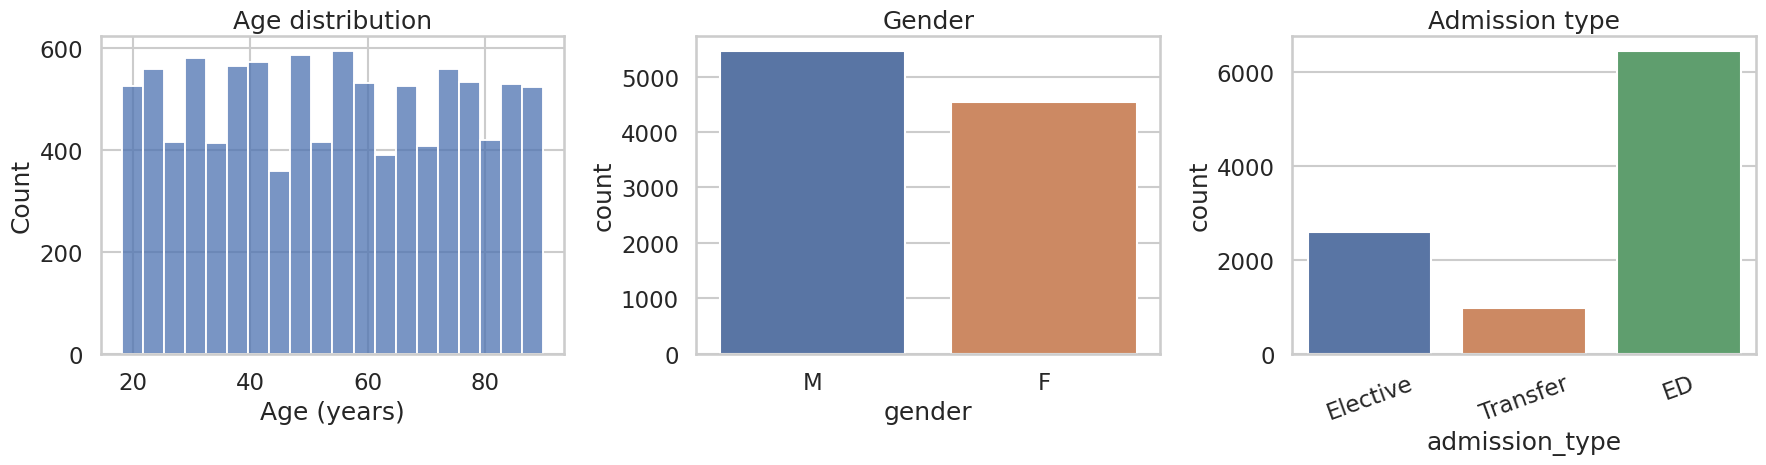

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(patients["age"], bins=20, ax=axes[0])
axes[0].set_title("Age distribution")
axes[0].set_xlabel("Age (years)")

sns.countplot(data=patients, x="gender", ax=axes[1])
axes[1].set_title("Gender")

sns.countplot(data=patients, x="admission_type", ax=axes[2])
axes[2].set_title("Admission type")
axes[2].tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()

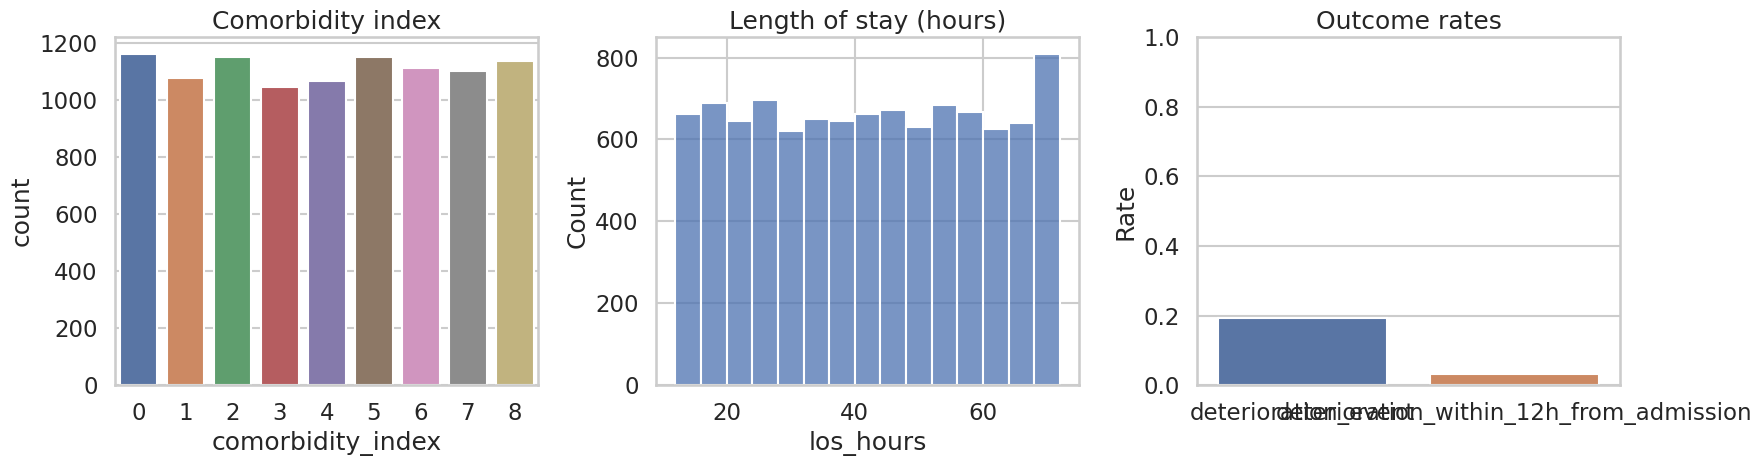

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(
    data=patients,
    x="comorbidity_index",
    ax=axes[0]
)
axes[0].set_title("Comorbidity index")

sns.histplot(patients["los_hours"], bins=15, ax=axes[1])
axes[1].set_title("Length of stay (hours)")

sns.barplot(
    x=["deterioration_event", "deterioration_within_12h_from_admission"],
    y=[
        patients["deterioration_event"].mean(),
        patients["deterioration_within_12h_from_admission"].mean(),
    ],
    ax=axes[2]
)
axes[2].set_ylim(0, 1)
axes[2].set_ylabel("Rate")
axes[2].set_title("Outcome rates")

plt.tight_layout()
plt.show()

### 3.3 Event funnel — from cohort to early events

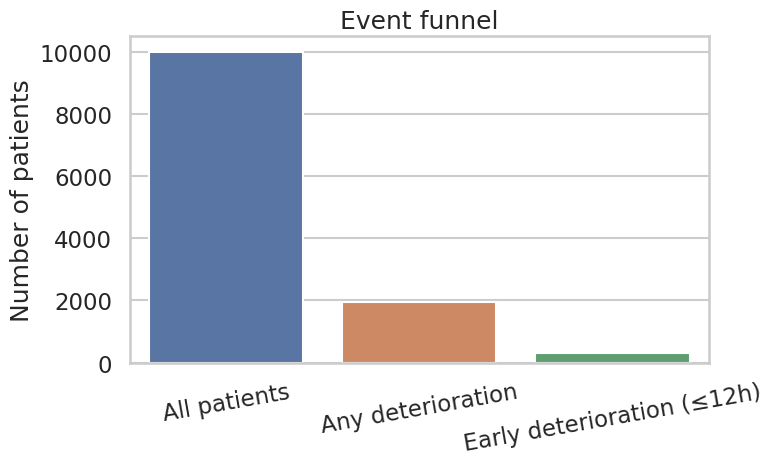

,stage,count
0,All patients,10000
1,Any deterioration,1938
2,Early deterioration (≤12h),309


In [12]:
total = len(patients)
any_det = patients["deterioration_event"].sum()
early_det = patients["deterioration_within_12h_from_admission"].sum()

funnel = pd.DataFrame(
    {
        "stage": [
            "All patients",
            "Any deterioration",
            "Early deterioration (≤12h)",
        ],
        "count": [total, any_det, early_det],
    }
)

plt.figure(figsize=(8, 5))
sns.barplot(data=funnel, x="stage", y="count")
plt.title("Event funnel")
plt.ylabel("Number of patients")
plt.xlabel("")
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()

funnel

### 3.4 Deterioration across comorbidity × length-of-stay bands

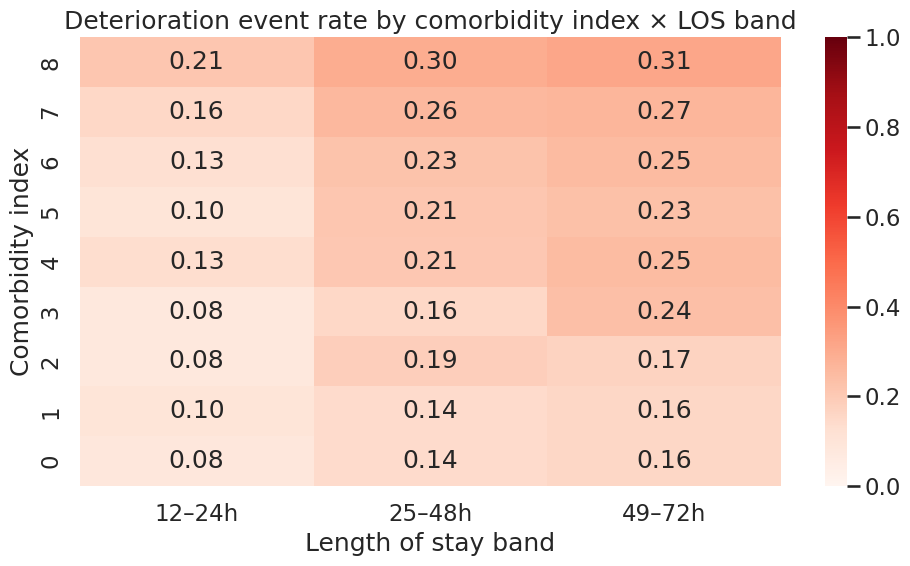

In [13]:
patients_heat = patients.copy()

patients_heat["los_band"] = pd.cut(
    patients_heat["los_hours"],
    bins=[11, 24, 48, 72],
    labels=["12–24h", "25–48h", "49–72h"],
)

pivot = (
    patients_heat
    .groupby(["comorbidity_index", "los_band"], observed=True)["deterioration_event"]
    .mean()
    .unstack()
    .sort_index(ascending=False)
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    vmin=0.0,
    vmax=1.0,
)
plt.title("Deterioration event rate by comorbidity index × LOS band")
plt.ylabel("Comorbidity index")
plt.xlabel("Length of stay band")
plt.tight_layout()
plt.show()

## 4. Stratified deterioration risk — who is higher risk?

In [14]:
patients_strat = patients.copy()

patients_strat["age_band"] = pd.cut(
    patients_strat["age"],
    bins=[17, 40, 60, 90],
    labels=["18–40", "41–60", "61–90"],
)

patients_strat["comorbidity_band"] = pd.cut(
    patients_strat["comorbidity_index"],
    bins=[-0.5, 0.5, 2.5, 4.5, 8.5],
    labels=["0", "1–2", "3–4", "5+"]
)

summary_strat = (
    patients_strat
    .groupby(["age_band", "comorbidity_band", "admission_type"], observed=True)
    .agg(
        n=("patient_id", "size"),
        event_rate=("deterioration_event", "mean"),
    )
    .reset_index()
)
summary_strat.head(10)

,age_band,comorbidity_band,admission_type,n,event_rate
0,18–40,0,ED,240,0.141667
1,18–40,0,Elective,90,0.066667
2,18–40,0,Transfer,36,0.138889
3,18–40,1–2,ED,458,0.109170
4,18–40,1–2,Elective,191,0.104712
5,18–40,1–2,Transfer,80,0.175000
6,18–40,3–4,ED,406,0.137931
7,18–40,3–4,Elective,176,0.142045
8,18–40,3–4,Transfer,65,0.215385
9,18–40,5+,ED,940,0.187234


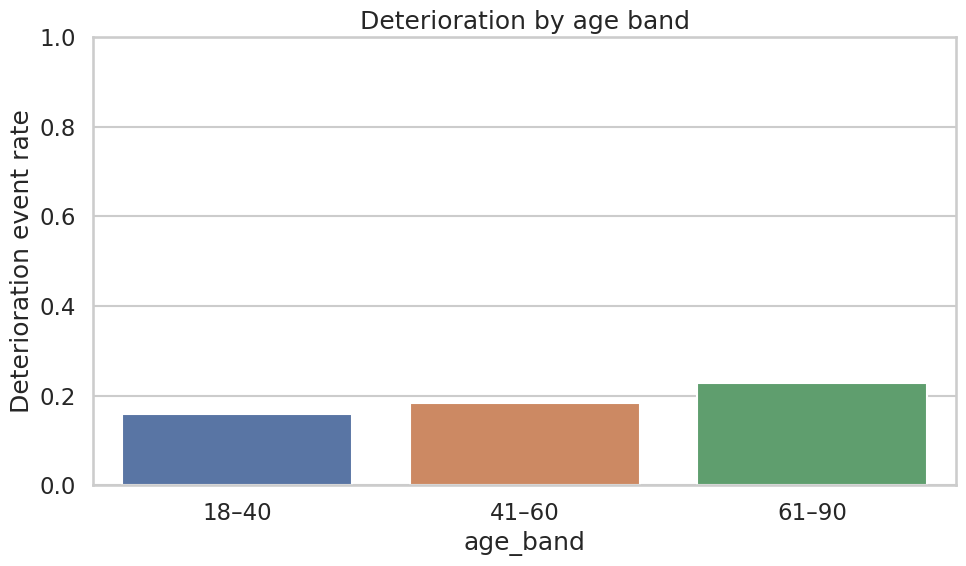

In [15]:
plt.figure(figsize=(10, 6))
pivot_age = (
    patients_strat
    .groupby("age_band")["deterioration_event"]
    .mean()
    .reset_index()
)
sns.barplot(data=pivot_age, x="age_band", y="deterioration_event")
plt.ylim(0, 1)
plt.ylabel("Deterioration event rate")
plt.title("Deterioration by age band")
plt.tight_layout()
plt.show()

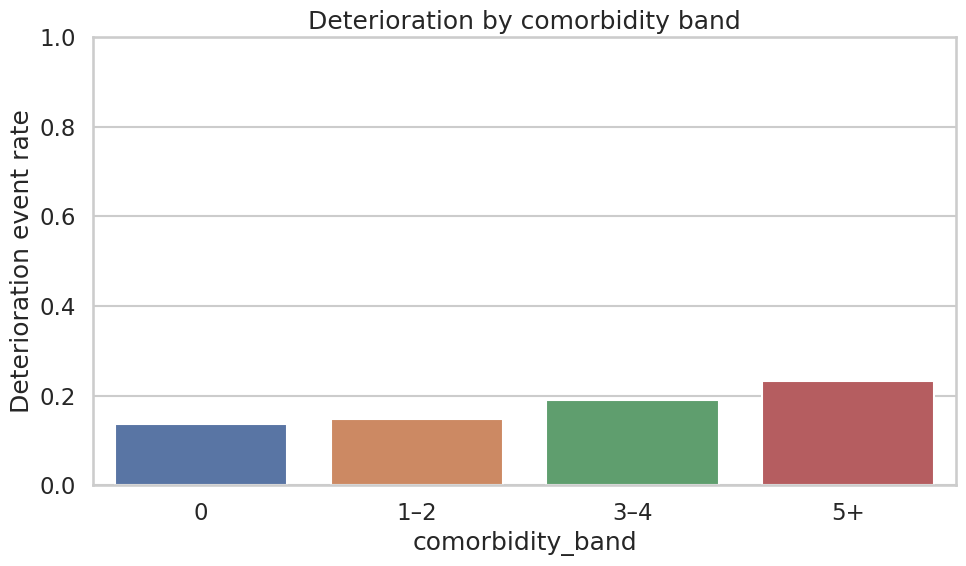

In [16]:
plt.figure(figsize=(10, 6))
pivot_comorb = (
    patients_strat
    .groupby("comorbidity_band")["deterioration_event"]
    .mean()
    .reset_index()
)
sns.barplot(data=pivot_comorb, x="comorbidity_band", y="deterioration_event")
plt.ylim(0, 1)
plt.ylabel("Deterioration event rate")
plt.title("Deterioration by comorbidity band")
plt.tight_layout()
plt.show()

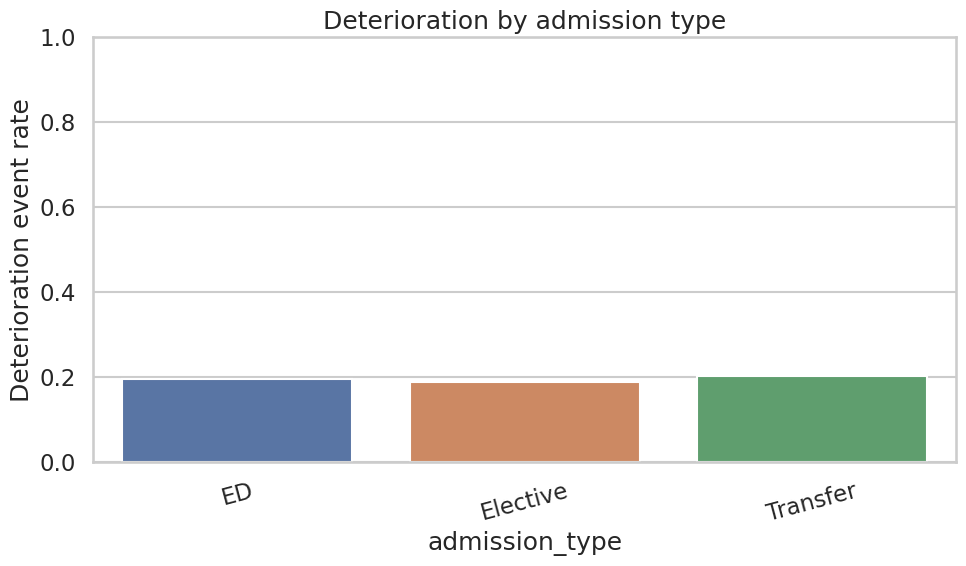

In [17]:
plt.figure(figsize=(10, 6))
pivot_adm = (
    patients_strat
    .groupby("admission_type")["deterioration_event"]
    .mean()
    .reset_index()
)
sns.barplot(data=pivot_adm, x="admission_type", y="deterioration_event")
plt.ylim(0, 1)
plt.ylabel("Deterioration event rate")
plt.title("Deterioration by admission type")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## 5. Timeline — when do patients deteriorate?

In [18]:
events = patients[patients["deterioration_event"] == 1].copy()
events = events[events["deterioration_hour"] >= 0]

events["time_band"] = pd.cut(
    events["deterioration_hour"],
    bins=[-0.5, 12.5, 24.5, 48.5, 72.5],
    labels=["0–12h", "13–24h", "25–48h", "49–72h"]
)

band_share = (
    events["time_band"]
    .value_counts(normalize=True)
    .sort_index()
    .rename("share")
    .reset_index()
    .rename(columns={"index": "time_band"})
)
band_share

,time_band,share
0,0–12h,0.159443
1,13–24h,0.351393
2,25–48h,0.386997
3,49–72h,0.102167


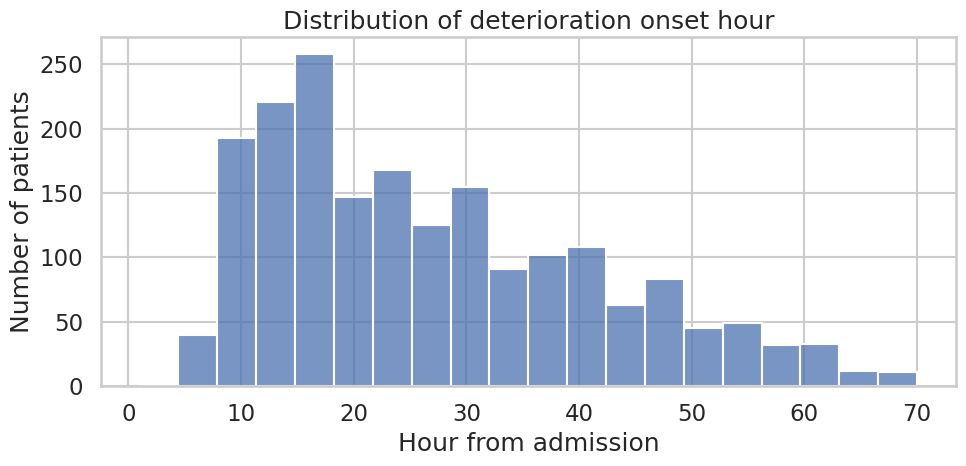

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot(events["deterioration_hour"], bins=20, kde=False)
plt.xlabel("Hour from admission")
plt.ylabel("Number of patients")
plt.title("Distribution of deterioration onset hour")
plt.tight_layout()
plt.show()

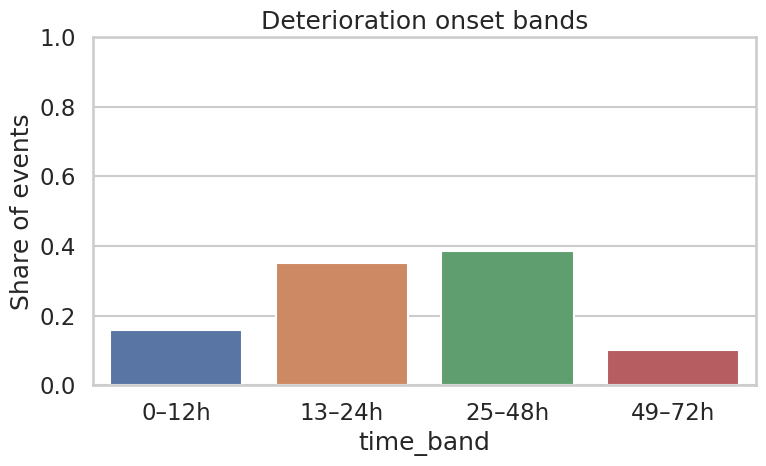

In [20]:
plt.figure(figsize=(8, 5))
sns.barplot(data=band_share, x="time_band", y="share")
plt.ylim(0, 1)
plt.ylabel("Share of events")
plt.title("Deterioration onset bands")
plt.tight_layout()
plt.show()

## 6. Baseline risk score vs observed outcomes

In [21]:
patients_risk = patients.copy()
patients_risk["risk_decile"] = pd.qcut(
    patients_risk["baseline_risk_score"],
    q=10,
    labels=[f"D{i}" for i in range(1, 11)]
)

calib = (
    patients_risk
    .groupby("risk_decile")
    .agg(
        mean_score=("baseline_risk_score", "mean"),
        event_rate=("deterioration_event", "mean"),
        early_event_rate=("deterioration_within_12h_from_admission", "mean"),
        n=("patient_id", "size"),
    )
    .reset_index()
    .sort_values("mean_score")
)
calib

,risk_decile,mean_score,event_rate,early_event_rate,n
0,D1,0.157232,0.099000,0.006000,1000
1,D2,0.256299,0.132000,0.013000,1000
2,D3,0.327448,0.145000,0.015000,1000
3,D4,0.398388,0.181000,0.021000,1000
4,D5,0.464844,0.193000,0.026000,1000
5,D6,0.531766,0.195804,0.029970,1001
6,D7,0.601052,0.209000,0.030000,1000
7,D8,0.671092,0.219219,0.037037,999
8,D9,0.747858,0.268731,0.067932,1001
9,D10,0.843396,0.295295,0.063063,999


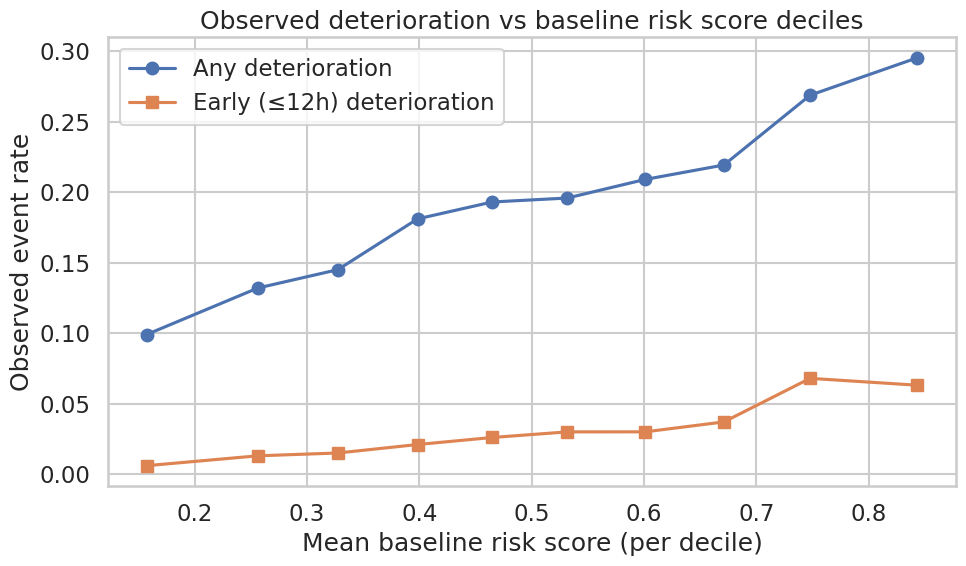

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(calib["mean_score"], calib["event_rate"], marker="o", label="Any deterioration")
ax.plot(calib["mean_score"], calib["early_event_rate"], marker="s", label="Early (≤12h) deterioration")

ax.set_xlabel("Mean baseline risk score (per decile)")
ax.set_ylabel("Observed event rate")
ax.set_title("Observed deterioration vs baseline risk score deciles")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

**Interpretation**

- Higher baseline risk deciles show higher deterioration rates.
- Early events are concentrated in the highest risk deciles.
- The latent `baseline_risk_score` behaves like a well-calibrated risk signal for this simulator.

## Part B — Time-series trajectories & physiologic behavior

## 7. Physiologic trajectories around deterioration events

In [23]:
vitals_ev = vitals.merge(
    patients[["patient_id", "deterioration_event", "deterioration_hour"]],
    on="patient_id",
    how="left"
)

vitals_ev = vitals_ev[vitals_ev["deterioration_event"] == 1].copy()
vitals_ev = vitals_ev[vitals_ev["deterioration_hour"] >= 0].copy()

vitals_ev["hours_to_event"] = (
    vitals_ev["deterioration_hour"] - vitals_ev["hour_from_admission"]
)

window = (-24, 0)
vitals_window = vitals_ev[
    (vitals_ev["hours_to_event"] >= window[0])
    & (vitals_ev["hours_to_event"] <= window[1])
].copy()

vitals_window[["hours_to_event", "heart_rate", "respiratory_rate", "spo2_pct", "temperature_c"]].head()

,hours_to_event,heart_rate,respiratory_rate,spo2_pct,temperature_c
33,0,81.06,27.33,93.02,37.24
34,-1,85.18,26.54,92.79,37.27
35,-2,84.49,25.07,91.92,37.26
36,-3,85.56,25.91,90.70,37.38
37,-4,87.30,27.95,90.67,37.40


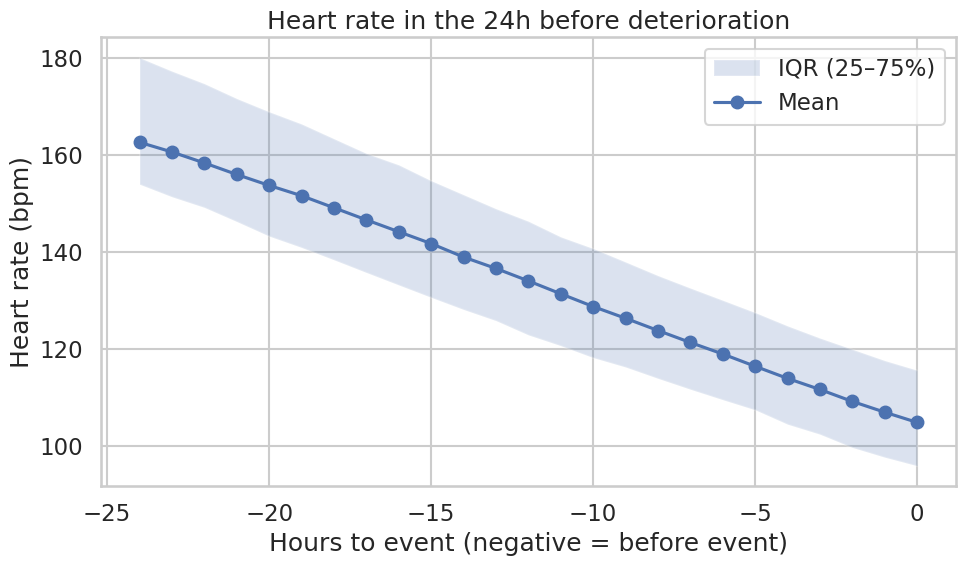

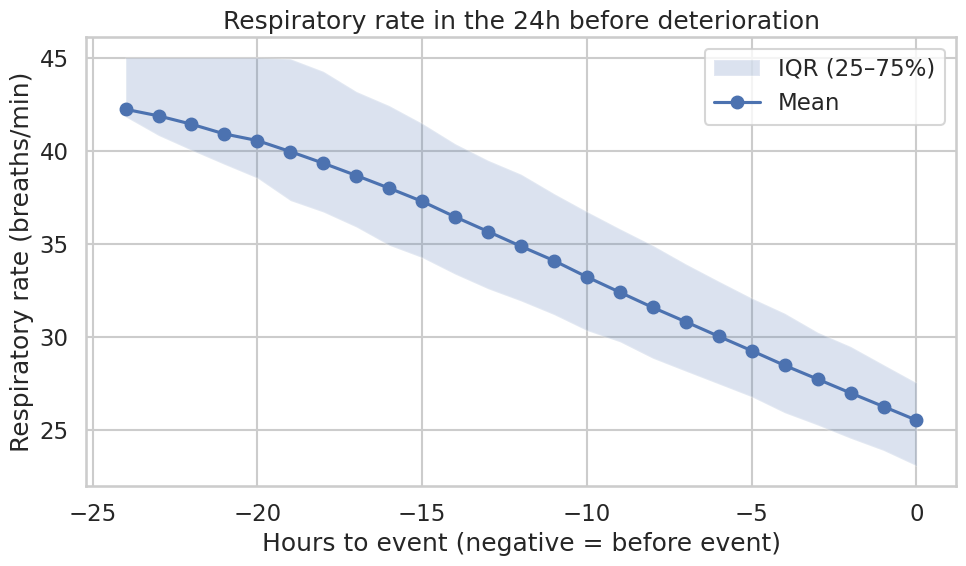

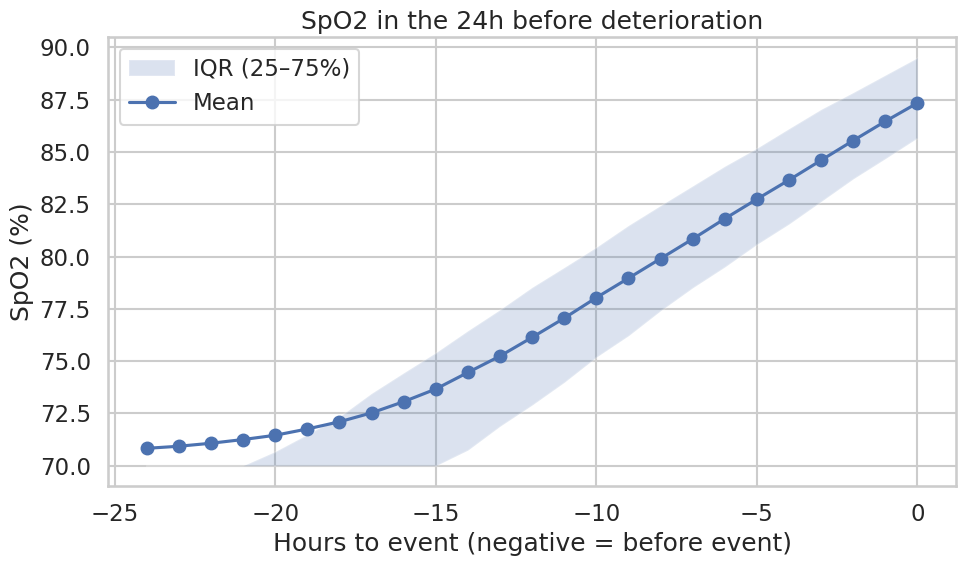

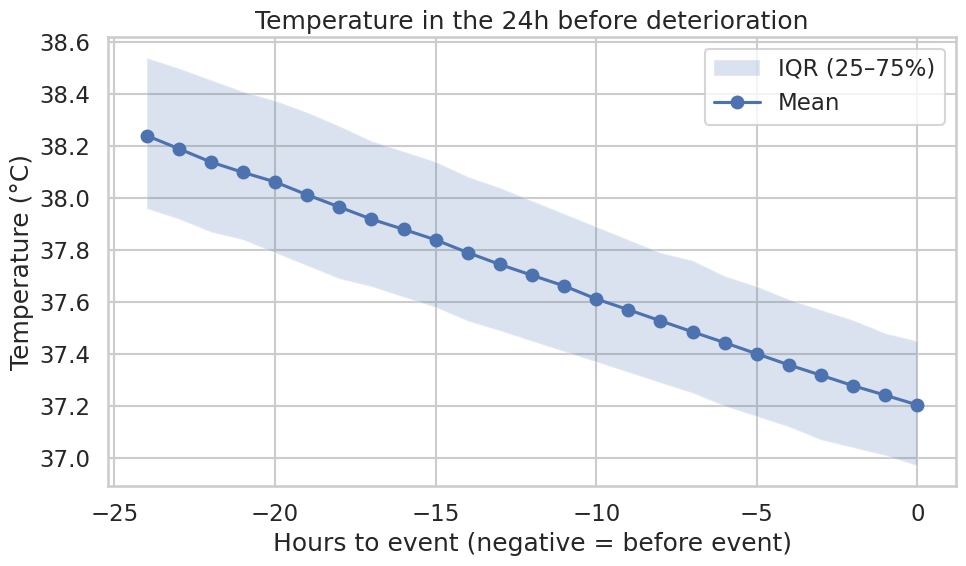

In [24]:
def plot_event_centered_with_iqr(df, feature: str, ylabel: str, title: str):
    grouped = df.groupby("hours_to_event")[feature]
    mean_curve = grouped.mean().sort_index()
    q25 = grouped.quantile(0.25).sort_index()
    q75 = grouped.quantile(0.75).sort_index()

    plt.figure(figsize=(10, 6))
    x = mean_curve.index
    plt.fill_between(x, q25, q75, alpha=0.2, label="IQR (25–75%)")
    plt.plot(x, mean_curve, marker="o", label="Mean")
    plt.xlabel("Hours to event (negative = before event)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_event_centered_with_iqr(vitals_window, "heart_rate", "Heart rate (bpm)", "Heart rate in the 24h before deterioration")
plot_event_centered_with_iqr(vitals_window, "respiratory_rate", "Respiratory rate (breaths/min)", "Respiratory rate in the 24h before deterioration")
plot_event_centered_with_iqr(vitals_window, "spo2_pct", "SpO2 (%)", "SpO2 in the 24h before deterioration")
plot_event_centered_with_iqr(vitals_window, "temperature_c", "Temperature (°C)", "Temperature in the 24h before deterioration")

## 8. Population-level trajectories (event vs no event)

In [25]:
vitals_merged = vitals.merge(
    patients[["patient_id", "deterioration_event"]],
    on="patient_id",
    how="left"
)

vitals_24 = vitals_merged[vitals_merged["hour_from_admission"] < 24].copy()

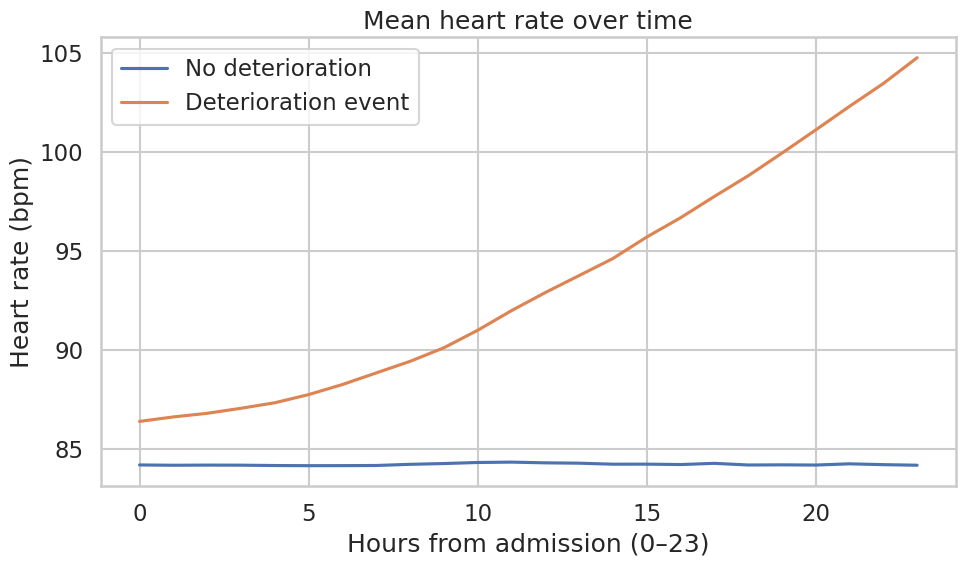

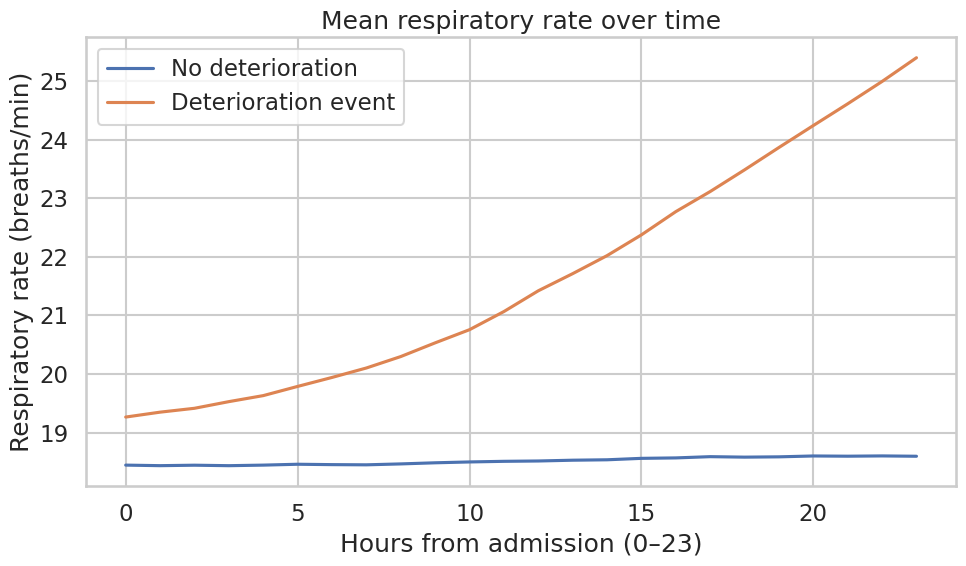

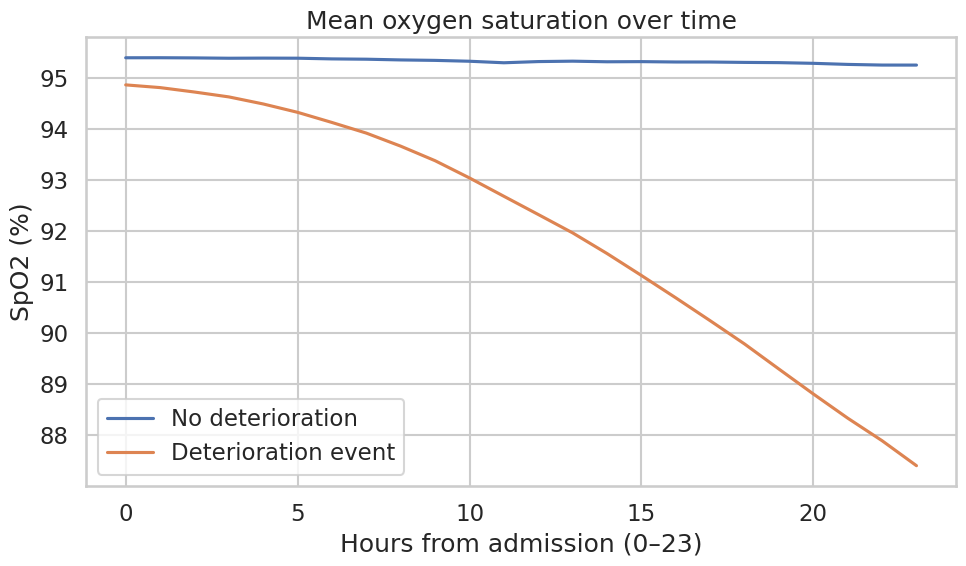

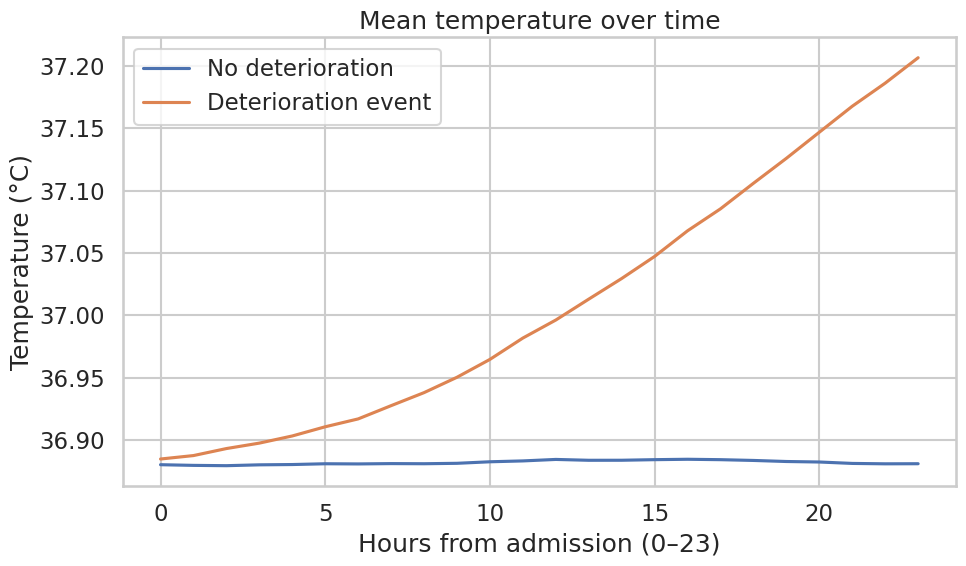

In [26]:
def plot_ts_mean(feature: str, ylabel: str, title: str):
    plt.figure(figsize=(10, 6))
    for event_flag, group in vitals_24.groupby("deterioration_event"):
        curve = (
            group
            .groupby("hour_from_admission")[feature]
            .mean()
            .sort_index()
        )
        label = "Deterioration event" if event_flag == 1 else "No deterioration"
        plt.plot(curve.index, curve.values, marker="", label=label)
    plt.xlabel("Hours from admission (0–23)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_ts_mean("heart_rate", "Heart rate (bpm)", "Mean heart rate over time")
plot_ts_mean("respiratory_rate", "Respiratory rate (breaths/min)", "Mean respiratory rate over time")
plot_ts_mean("spo2_pct", "SpO2 (%)", "Mean oxygen saturation over time")
plot_ts_mean("temperature_c", "Temperature (°C)", "Mean temperature over time")

In [27]:
labs_merged = labs.merge(
    patients[["patient_id", "deterioration_event"]],
    on="patient_id",
    how="left"
)

labs_24 = labs_merged[labs_merged["hour_from_admission"] < 24].copy()

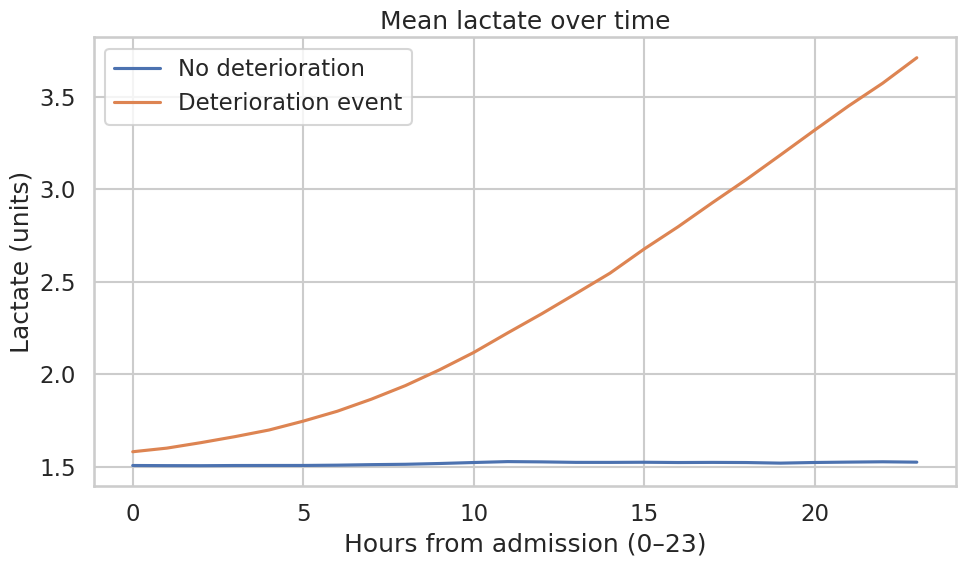

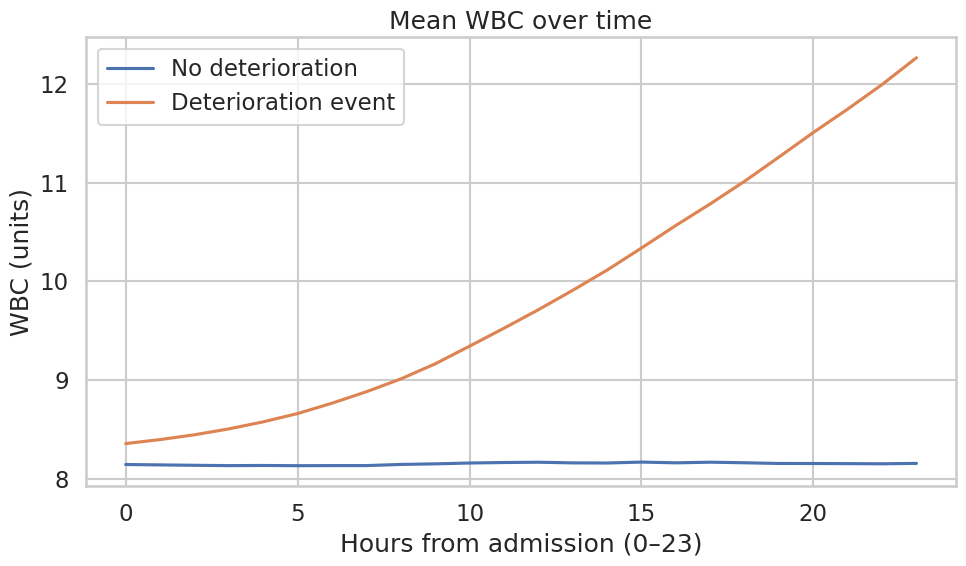

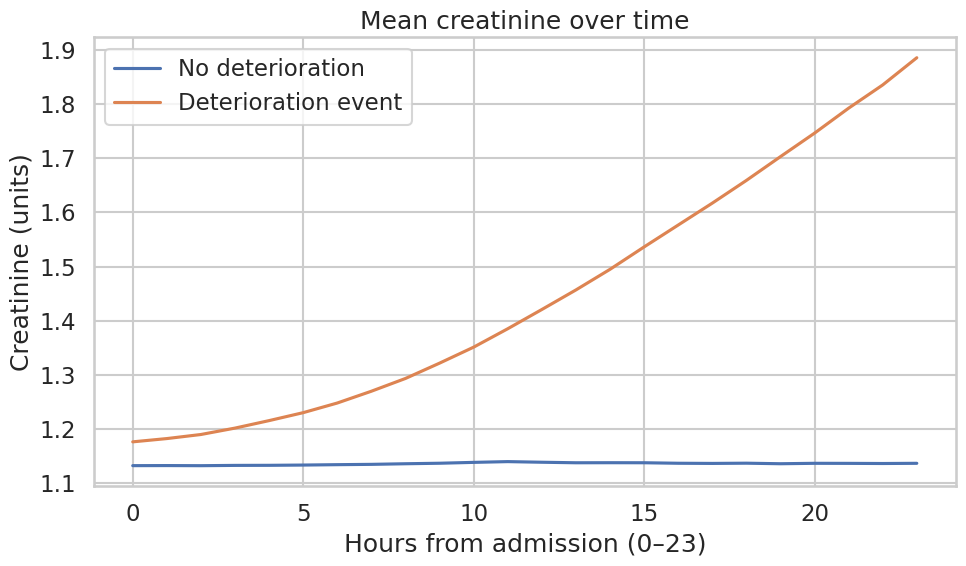

In [28]:
def plot_labs_ts_mean(feature: str, ylabel: str, title: str):
    plt.figure(figsize=(10, 6))
    for event_flag, group in labs_24.groupby("deterioration_event"):
        curve = (
            group
            .groupby("hour_from_admission")[feature]
            .mean()
            .sort_index()
        )
        label = "Deterioration event" if event_flag == 1 else "No deterioration"
        plt.plot(curve.index, curve.values, marker="", label=label)
    plt.xlabel("Hours from admission (0–23)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_labs_ts_mean("lactate", "Lactate (units)", "Mean lactate over time")
plot_labs_ts_mean("wbc_count", "WBC (units)", "Mean WBC over time")
plot_labs_ts_mean("creatinine", "Creatinine (units)", "Mean creatinine over time")

## Part C — Early physiologic phenotypes

## 9. Early physiologic phenotypes (KMeans clustering)

In [29]:
# Aggregate early vitals (0–6h)
v_early = vitals[vitals["hour_from_admission"] < 6].copy()
v_agg = (
    v_early
    .groupby("patient_id")[
        ["heart_rate", "respiratory_rate", "spo2_pct", "temperature_c", "systolic_bp", "diastolic_bp"]
    ]
    .mean()
)

# Aggregate early labs (0–6h)
l_early = labs[labs["hour_from_admission"] < 6].copy()
l_agg = (
    l_early
    .groupby("patient_id")[
        ["wbc_count", "lactate", "creatinine", "crp_level", "hemoglobin"]
    ]
    .mean()
)

early_feats = v_agg.join(l_agg, how="inner")
early_feats.head()

,heart_rate,respiratory_rate,spo2_pct,temperature_c,systolic_bp,diastolic_bp,wbc_count,lactate,creatinine,crp_level,hemoglobin
patient_id,,,,,,,,,,,
1,70.078333,14.741667,95.185000,37.246667,110.411667,77.378333,5.780000,1.183333,1.233333,11.245000,13.595000
2,81.271667,20.760000,96.748333,37.010000,104.956667,67.588333,7.170000,1.623333,1.100000,24.163333,12.238333
3,83.956667,24.560000,92.916667,36.781667,128.516667,81.665000,11.493333,1.888333,0.923333,22.091667,13.201667
4,82.298333,13.671667,96.576667,36.725000,108.341667,77.195000,6.563333,1.031667,1.063333,40.805000,13.303333
5,76.918333,14.561667,95.540000,37.280000,136.885000,65.618333,8.536667,0.851667,0.766667,2.248333,11.795000


In [30]:
# Merge outcomes & static context
early_feats = early_feats.merge(
    patients[["patient_id", "deterioration_event", "baseline_risk_score", "comorbidity_index"]],
    on="patient_id",
    how="left"
)

feature_cols = [
    c for c in early_feats.columns
    if c not in ["deterioration_event", "baseline_risk_score", "comorbidity_index"]
]

X_early = early_feats[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_early)

kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

early_feats["cluster"] = cluster_labels
early_feats["cluster"].value_counts().sort_index()

cluster
0    4044
1    2790
2    3166
Name: count, dtype: int64

In [31]:
cluster_summary = (
    early_feats
    .groupby("cluster")
    .agg(
        n=("patient_id", "size"),
        event_rate=("deterioration_event", "mean"),
        mean_baseline_risk=("baseline_risk_score", "mean"),
        mean_comorbidity=("comorbidity_index", "mean"),
    )
    .reset_index()
)
cluster_summary

,cluster,n,event_rate,mean_baseline_risk,mean_comorbidity
0,0,4044,0.183976,0.509304,4.243818
1,1,2790,0.297133,0.676644,6.640143
2,2,3166,0.115287,0.332179,1.363866


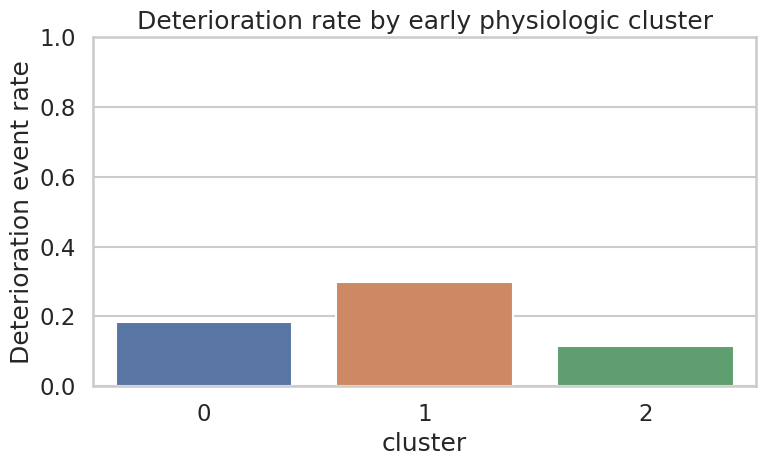

In [32]:
plt.figure(figsize=(8, 5))
sns.barplot(data=cluster_summary, x="cluster", y="event_rate")
plt.ylim(0, 1)
plt.ylabel("Deterioration event rate")
plt.title("Deterioration rate by early physiologic cluster")
plt.tight_layout()
plt.show()

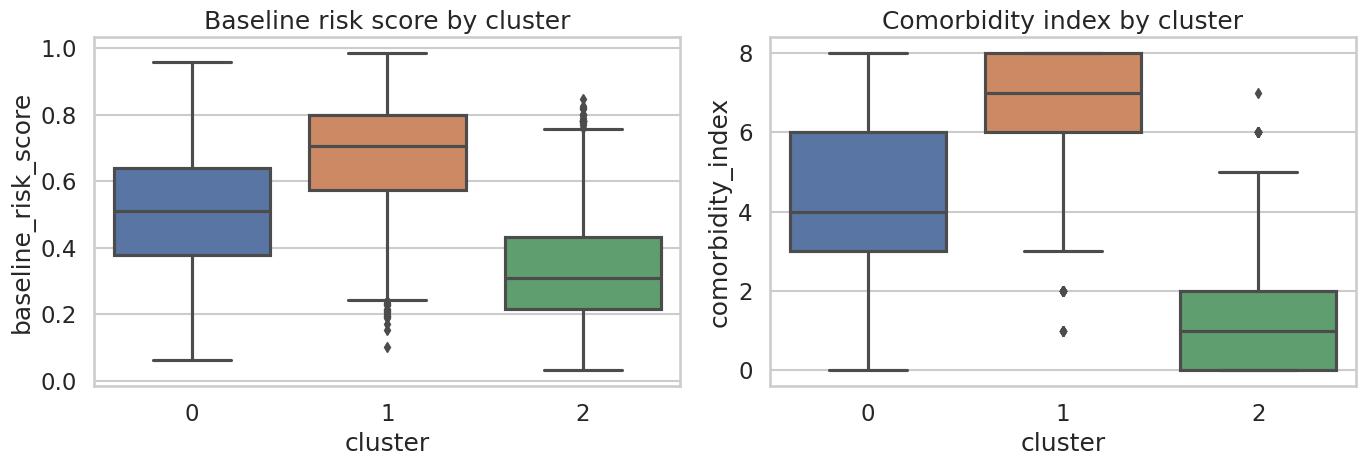

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=early_feats, x="cluster", y="baseline_risk_score", ax=axes[0])
axes[0].set_title("Baseline risk score by cluster")

sns.boxplot(data=early_feats, x="cluster", y="comorbidity_index", ax=axes[1])
axes[1].set_title("Comorbidity index by cluster")

plt.tight_layout()
plt.show()

### 9.1 Early physiologic phenotypes in 2D (PCA map)

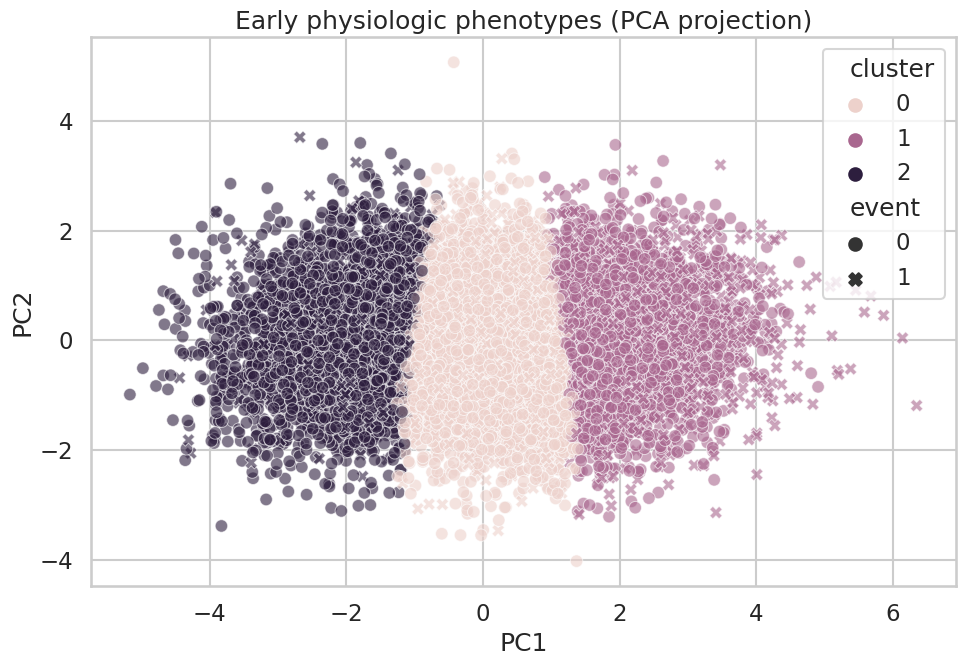

In [34]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(
    {
        "pc1": X_pca[:, 0],
        "pc2": X_pca[:, 1],
        "cluster": early_feats["cluster"].values,
        "event": early_feats["deterioration_event"].values,
    }
)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df,
    x="pc1",
    y="pc2",
    hue="cluster",
    style="event",
    alpha=0.6,
)
plt.title("Early physiologic phenotypes (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

## Part D — Next-12h label, risk “hot zones” & alert policy

## 10. Early-warning perspective from the ML-ready table

In [35]:
ml_ready["deterioration_next_12h"].value_counts(normalize=True)

deterioration_next_12h
0    0.945942
1    0.054058
Name: proportion, dtype: float64

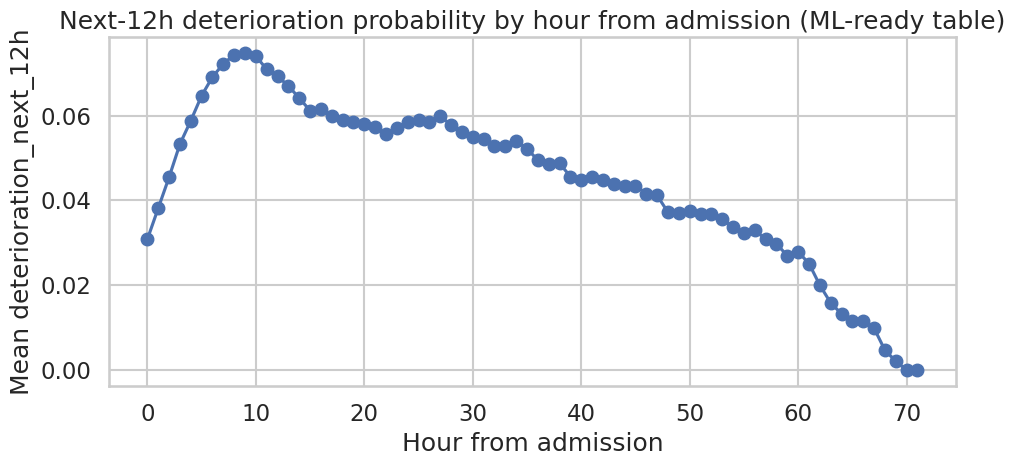

In [36]:
risk_by_hour = (
    ml_ready
    .groupby("hour_from_admission")["deterioration_next_12h"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 5))
plt.plot(risk_by_hour["hour_from_admission"], risk_by_hour["deterioration_next_12h"], marker="o")
plt.xlabel("Hour from admission")
plt.ylabel("Mean deterioration_next_12h")
plt.title("Next-12h deterioration probability by hour from admission (ML-ready table)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
numeric_cols = [
    col for col in ml_ready.columns
    if ml_ready[col].dtype != "object"
]

corr = ml_ready[numeric_cols].corr()
corr_target = corr["deterioration_next_12h"].sort_values(ascending=False)
corr_target.head(10)

deterioration_next_12h    1.000000
sepsis_risk_score         0.133122
nurse_alert               0.091895
lactate                   0.081906
respiratory_rate          0.059948
creatinine                0.056667
heart_rate                0.054973
comorbidity_index         0.051697
wbc_count                 0.047712
crp_level                 0.046270
Name: deterioration_next_12h, dtype: float64

In [38]:
top_features = (
    corr_target
    .drop(labels=["deterioration_next_12h"])
    .abs()
    .sort_values(ascending=False)
    .head(6)
    .index.tolist()
)
top_features

['mobility_score',
 'sepsis_risk_score',
 'nurse_alert',
 'systolic_bp',
 'lactate',
 'spo2_pct']

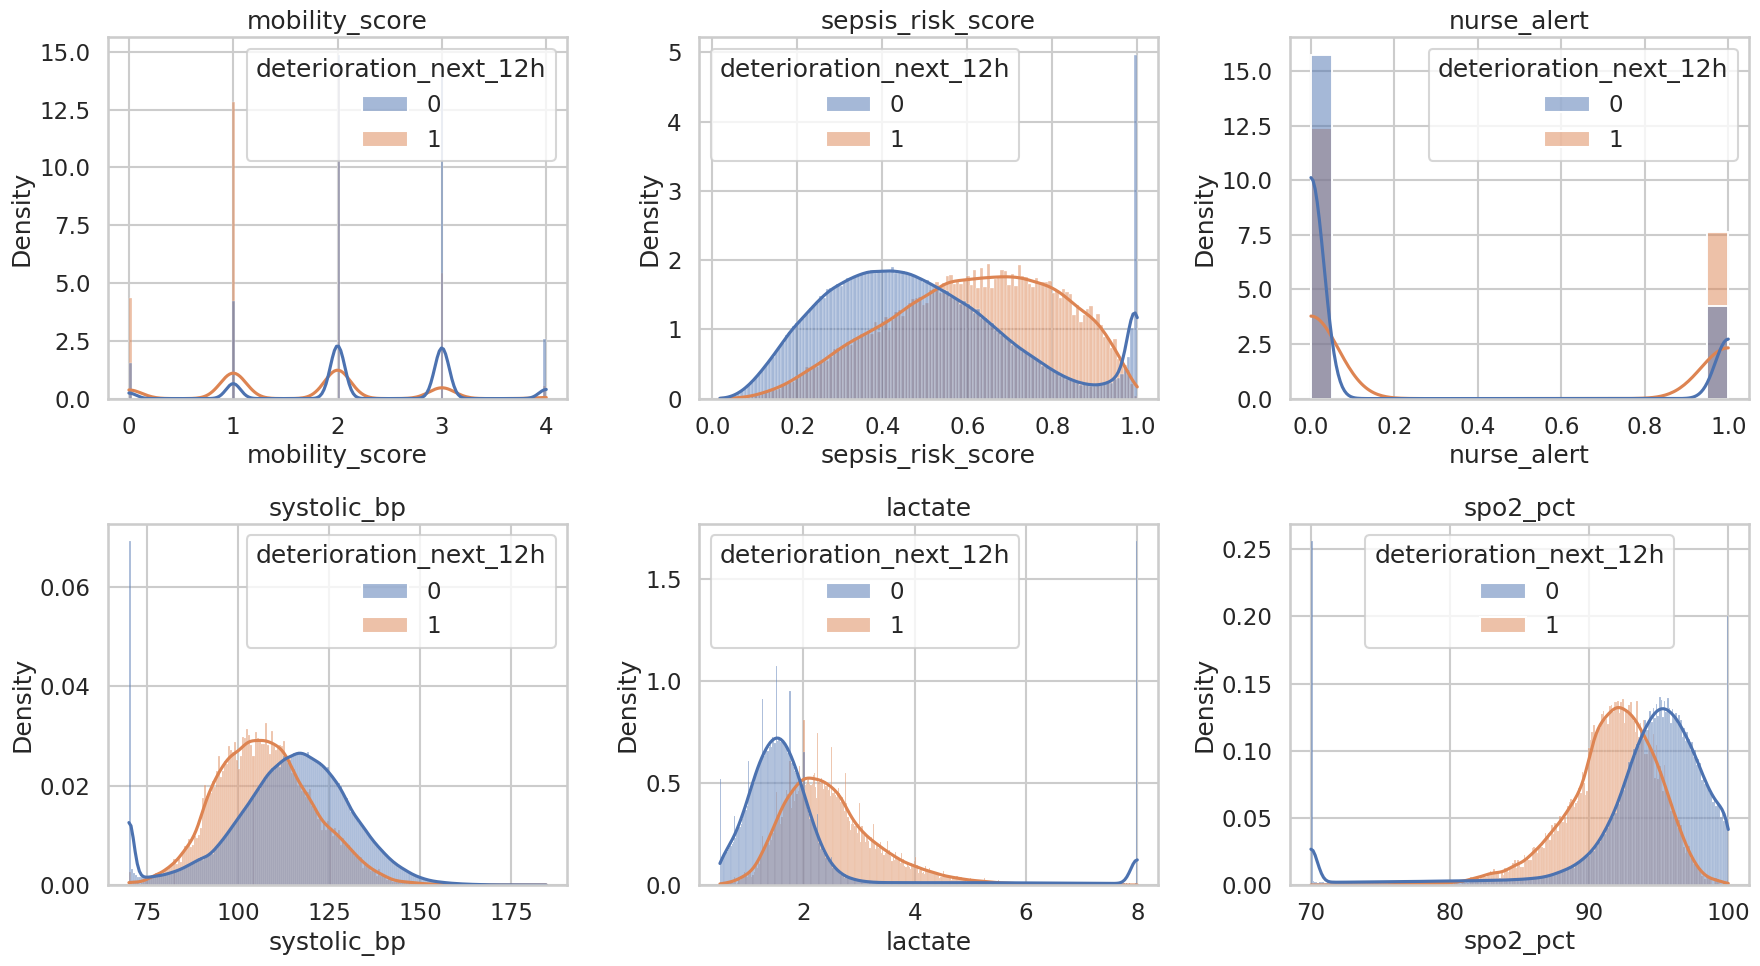

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for ax, feature in zip(axes, top_features):
    sns.histplot(
        data=ml_ready,
        x=feature,
        hue="deterioration_next_12h",
        stat="density",
        common_norm=False,
        kde=True,
        ax=ax,
    )
    ax.set_title(feature)

for ax in axes[len(top_features):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

## 11. Consistency check: oxygen device vs flow

In [40]:
mask_inconsistent = (
    (ml_ready["oxygen_device"] == "none")
    & (ml_ready["oxygen_flow"] > 0)
)

mask_inconsistent.sum(), ml_ready.shape[0]

(0, 417866)

## 12. Patient storyboards — making the cohort feel real

In [41]:
# Pick one deteriorating patient and one non-deteriorating patient
pat_det = patients[patients["deterioration_event"] == 1]["patient_id"].sample(1, random_state=RANDOM_STATE).iloc[0]
pat_nodet = patients[patients["deterioration_event"] == 0]["patient_id"].sample(1, random_state=RANDOM_STATE).iloc[0]

pat_det, pat_nodet

(3089, 930)

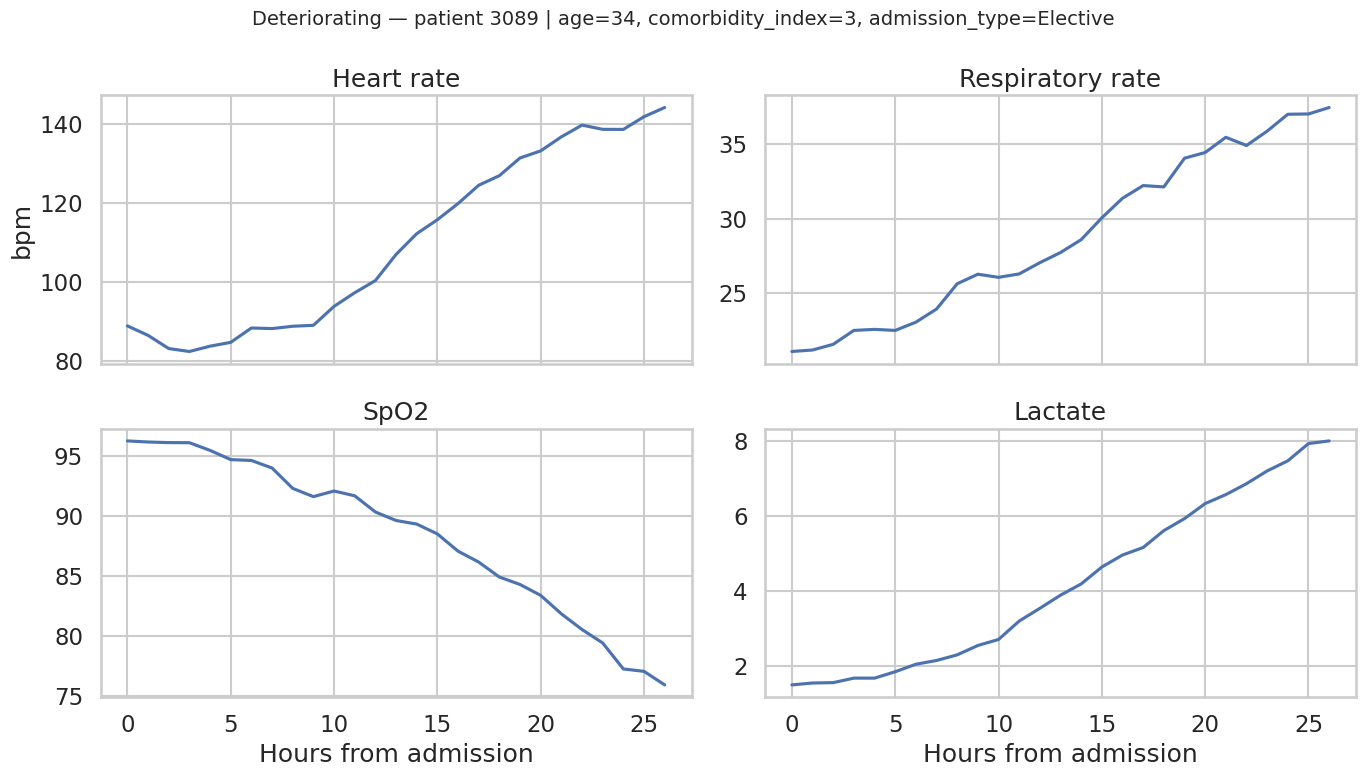

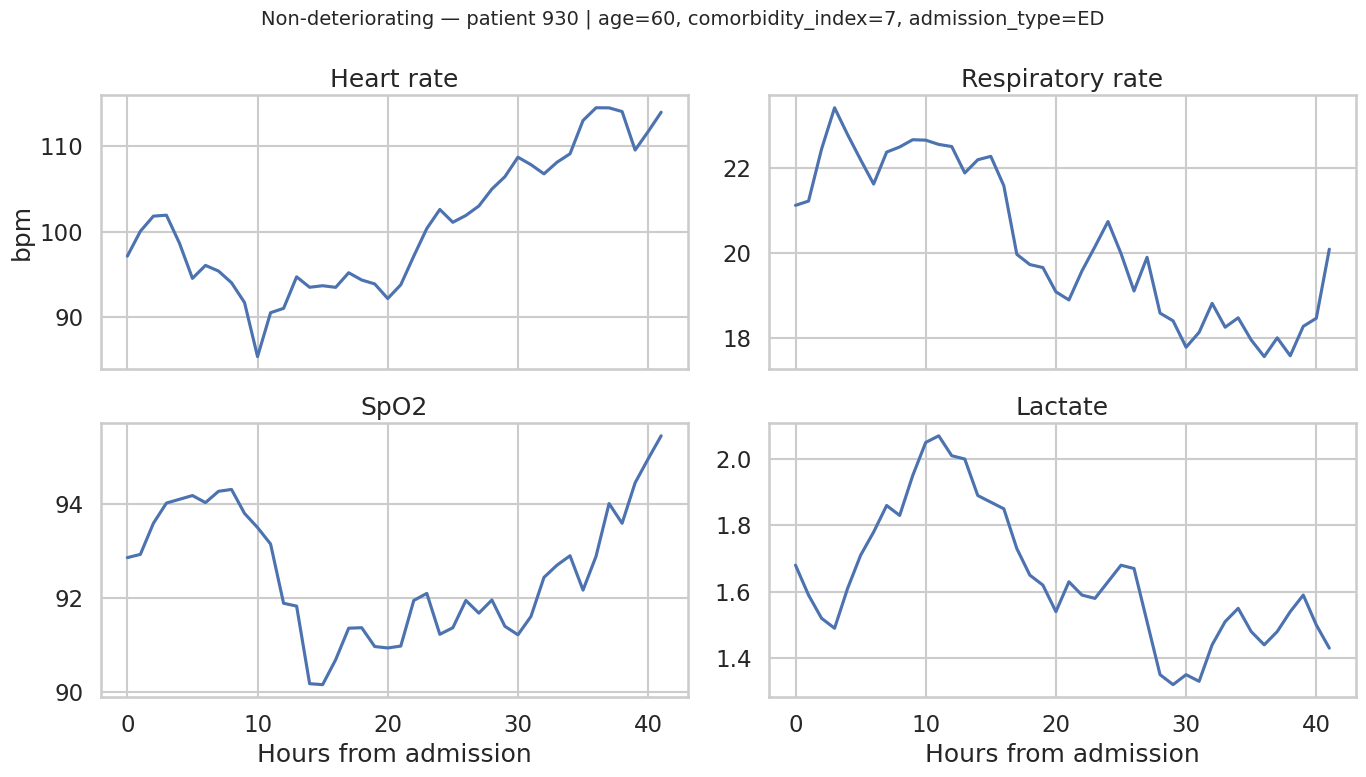

In [42]:
def plot_patient_story(patient_id: int, title_prefix: str):
    v_sub = vitals[vitals["patient_id"] == patient_id].sort_values("hour_from_admission")
    l_sub = labs[labs["patient_id"] == patient_id].sort_values("hour_from_admission")
    p_row = patients.set_index("patient_id").loc[patient_id]

    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
    fig.suptitle(
        f"{title_prefix} — patient {patient_id} | "
        f"age={p_row['age']}, comorbidity_index={p_row['comorbidity_index']}, "
        f"admission_type={p_row['admission_type']}",
        fontsize=14,
    )

    axes[0, 0].plot(v_sub["hour_from_admission"], v_sub["heart_rate"])
    axes[0, 0].set_title("Heart rate")
    axes[0, 0].set_ylabel("bpm")

    axes[0, 1].plot(v_sub["hour_from_admission"], v_sub["respiratory_rate"])
    axes[0, 1].set_title("Respiratory rate")

    axes[1, 0].plot(v_sub["hour_from_admission"], v_sub["spo2_pct"])
    axes[1, 0].set_title("SpO2")

    axes[1, 1].plot(l_sub["hour_from_admission"], l_sub["lactate"])
    axes[1, 1].set_title("Lactate")

    for ax in axes[-1, :]:
        ax.set_xlabel("Hours from admission")

    plt.tight_layout()
    plt.show()

plot_patient_story(pat_det, "Deteriorating")
plot_patient_story(pat_nodet, "Non-deteriorating")

## 13. Hour × baseline risk decile heatmap for next-12h label

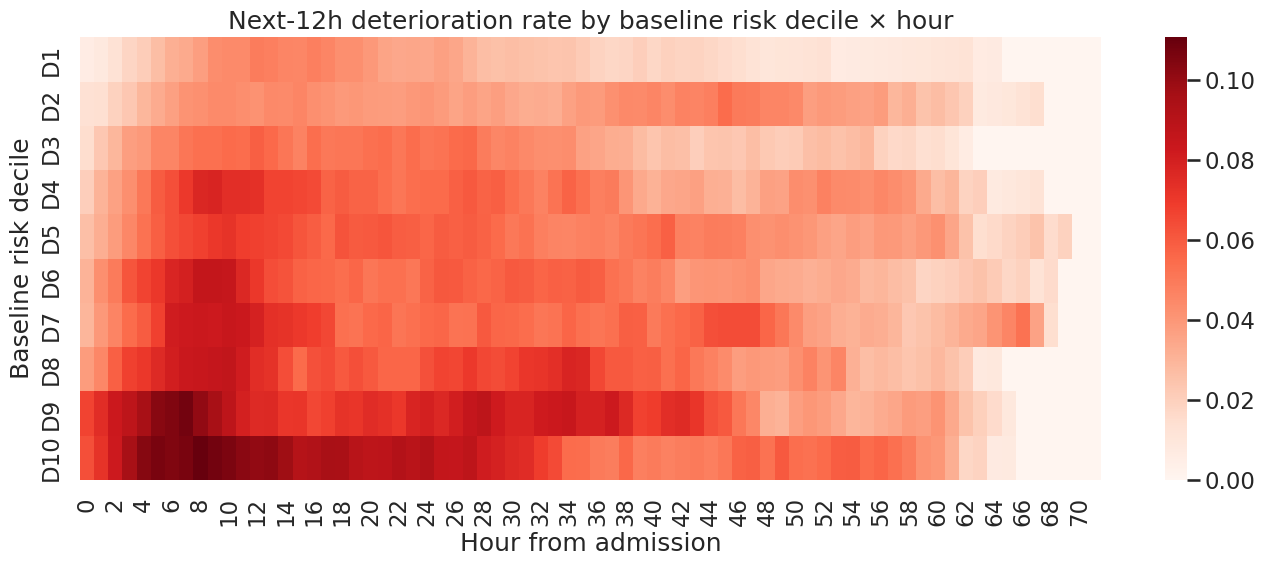

In [43]:
panel_risk = panel.copy()

panel_risk["risk_decile"] = pd.qcut(
    panel_risk["baseline_risk_score"],
    q=10,
    labels=[f"D{i}" for i in range(1, 11)]
)

heat = (
    panel_risk
    .groupby(["risk_decile", "hour_from_admission"])["deterioration_next_12h"]
    .mean()
    .reset_index()
)

heat_pivot = heat.pivot(
    index="risk_decile",
    columns="hour_from_admission",
    values="deterioration_next_12h",
)

plt.figure(figsize=(14, 6))
sns.heatmap(
    heat_pivot,
    cmap="Reds",
    vmin=0.0,
    vmax=heat["deterioration_next_12h"].max(),
)
plt.title("Next-12h deterioration rate by baseline risk decile × hour")
plt.xlabel("Hour from admission")
plt.ylabel("Baseline risk decile")
plt.tight_layout()
plt.show()

## 14. Simple alert policy view (baseline_risk_score as risk)

In [44]:
policy_view = panel.copy()

y = policy_view["deterioration_next_12h"].values
score = policy_view["baseline_risk_score"].values

thresholds = np.linspace(0.1, 0.9, 17)

rows = []
for th in thresholds:
    alerts = score >= th
    if alerts.sum() == 0:
        continue

    tp = (alerts & (y == 1)).sum()
    fp = (alerts & (y == 0)).sum()
    fn = (~alerts & (y == 1)).sum()

    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    alert_rate = alerts.mean()

    rows.append(
        {
            "threshold": th,
            "recall": recall,
            "precision": precision,
            "alerts_per_100": alert_rate * 100,
        }
    )

policy_df = pd.DataFrame(rows)
policy_df

,threshold,recall,precision,alerts_per_100
0,0.10,0.994688,0.054379,98.882178
1,0.15,0.977290,0.054907,96.217448
2,0.20,0.958298,0.056468,91.739218
3,0.25,0.922750,0.057909,86.139337
4,0.30,0.873478,0.059766,79.005949
5,0.35,0.814157,0.061313,71.781624
6,0.40,0.755500,0.062904,64.925359
7,0.45,0.679313,0.063964,57.411228
8,0.50,0.602727,0.065725,49.573787
9,0.55,0.528709,0.067218,42.519851


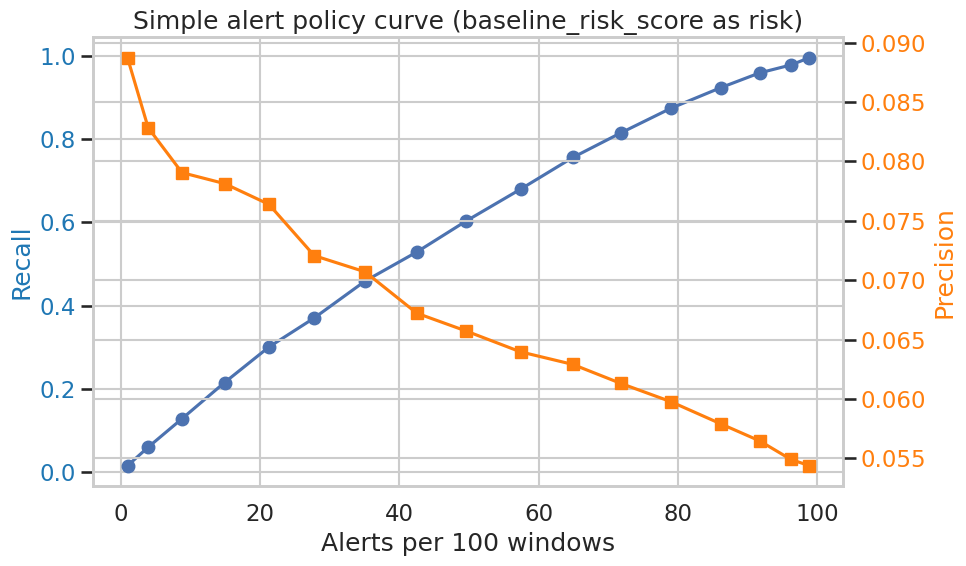

In [45]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(
    policy_df["alerts_per_100"],
    policy_df["recall"],
    marker="o",
    label="Recall",
)
ax1.set_xlabel("Alerts per 100 windows")
ax1.set_ylabel("Recall", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(
    policy_df["alerts_per_100"],
    policy_df["precision"],
    marker="s",
    color="tab:orange",
    label="Precision",
)
ax2.set_ylabel("Precision", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

plt.title("Simple alert policy curve (baseline_risk_score as risk)")
fig.tight_layout()
plt.show()

## 15. Summary & next steps

This notebook turns the Hospital Deterioration dataset into a **clear, modeling-ready view** for early warning:

- Built a concise cohort KPI snapshot and event funnel.
- Profiled deterioration risk by age, comorbidity, admission route, and length of stay.
- Described when deterioration occurs in the first 72 hours.
- Verified the behaviour of the baseline risk score as a usable latent risk signal.
- Explored physiologic trajectories before events and contrasted event vs non-event patients.
- Derived early physiologic clusters, mapped them in 2D, and analysed next-12h risk “hot zones”.
- Added a simple alert policy curve and patient storyboards to connect risk structure to operational intuition.

